In [1]:
# dependencies and setup

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gmaps
import time
from config import gkey
import matplotlib.image as mpimg

In [2]:
# file path stored as a variable
file = "sdhousing_w_redfin_csv.csv"
file1="ziplogltgfin.csv"
file2="Median Income house and population.csv"

In [3]:
sd_housing_20y_df = pd.read_csv(file2)
sd_housing_20y_df.head()

,DATE,median home income,population,median home price
0,1997,39427,2692.600,182710.1287
1,1998,41909,2736.720,208965.0632
2,1999,44009,2789.593,232308.7306
3,2000,48363,2826.314,267405.9260
4,2001,47944,2867.449,306075.8043


<Figure size 432x288 with 0 Axes>

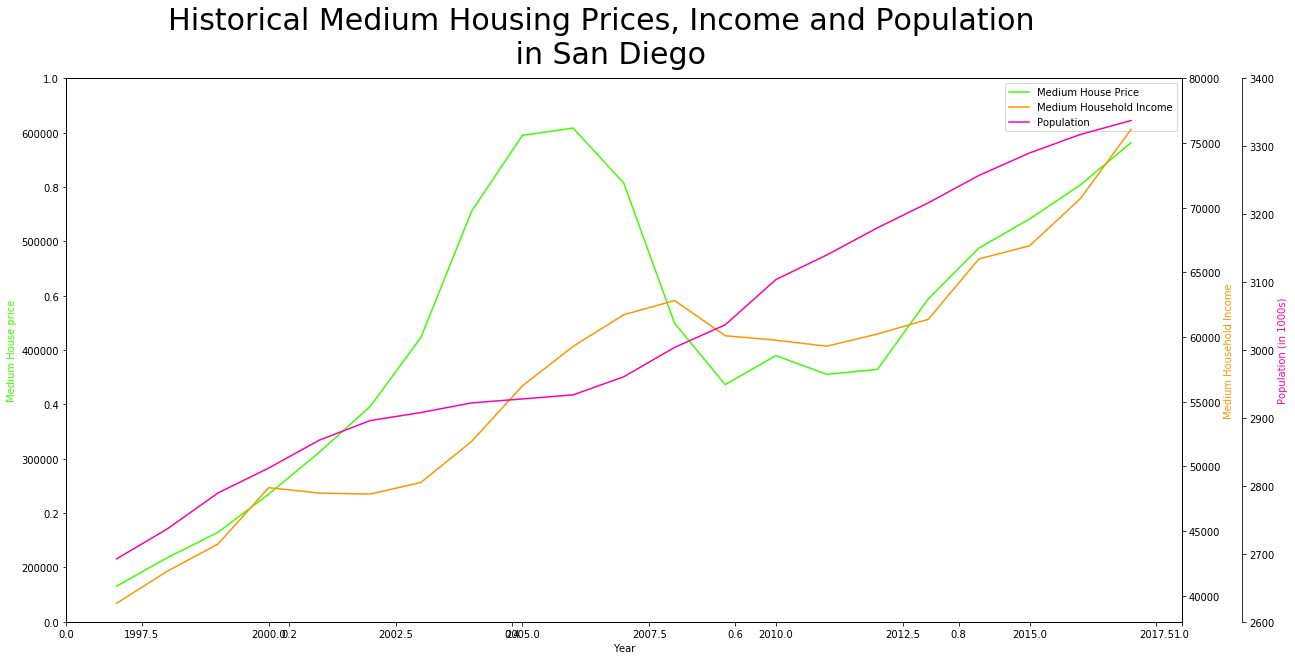

In [44]:
t = sd_housing_20y_df["DATE"]
data1=sd_housing_20y_df["median home income"]
data2=sd_housing_20y_df["population"]
data3=sd_housing_20y_df["median home price"]

fig = plt.figure()
fig, ax1 = plt.subplots(figsize=(20, 10)) 
host = fig.add_subplot(111)

par1 = host.twinx()
par2 = host.twinx()

host.set_xlim(1996, 2018)
host.set_ylim(150000, 650000)
par1.set_ylim(38000, 80000)
par2.set_ylim(2600, 3400)

host.set_xlabel("Year")
host.set_ylabel("Medium House price")
par1.set_ylabel("Medium Household Income")
par2.set_ylabel("Population (in 1000s)")

color1 = plt.cm.hsv(0.3)
color2 = plt.cm.hsv(0.1)
color3 = plt.cm.hsv(.9)

p1, = host.plot(t,data3, color=color1,label="Medium House Price")
p2, = par1.plot(t,data1, color=color2, label="Medium Household Income")
p3, = par2.plot(t,data2, color=color3, label="Population")

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))      

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())
fig.suptitle("Historical Medium Housing Prices, Income and Population \n in San Diego", fontsize=30)
plt.savefig("SD_Historical_Values.png", bbox_inches='tight')

In [5]:
# read the csv in
sd_housing_df = pd.read_csv(file)
sd_zip_df=pd.read_csv(file1)
sd_housing_pd=pd.merge(sd_zip_df,sd_housing_df,on="zip")
# display to verify
sd_housing_pd.head()

,zip,latitude,longitude,GEO_NAME,med_home_sale_1_12,med_home_sale_1_15,med_home_sale_1_18,pop_2011,pop_2014,pop_2017,...,total_units_17,ownocc_units_11,ownocc_units_14,ownocc_units_17,rent_units_11,rent_units_14,rent_units_17,median_gross_rent_11,median_gross_rent_14,median_gross_rent_17
0,91901,32.823102,-116.73864,Alpine California,390.0,490.0,632.0,16606,18184,18238,...,17813,11259,12843,13642,4845,4939,4171,1274,1284,1397
1,91902,32.663803,-117.02456,Bonita California,405.0,595.0,632.0,17399,19504,19762,...,19699,14192,15009,13997,3187,4447,5702,1462,1653,1777
2,91910,32.638654,-117.06686,Chula Vista California,250.0,389.0,508.0,71887,76797,76250,...,75145,38566,37110,36004,32504,38753,39141,1137,1189,1298
3,91911,32.608799,-117.06070,Chula Vista California,245.0,364.0,470.0,79518,83710,84025,...,83096,42313,41658,42151,36788,41399,40945,1154,1210,1359
4,91913,32.642486,-116.98973,Chula Vista California,305.0,420.0,517.0,40633,43655,49346,...,49337,29091,31864,35928,11542,11786,13409,1831,1823,1947


In [6]:
# check # of rows before edit
print(len(sd_housing_pd))

87


In [7]:
# remove rows where med_hh_inc_11 = "-", this eliminates many other rows that lack data
sd_housing_df_clean1 = sd_housing_pd[sd_housing_pd.med_hh_inc_11 != "-"]
# reset the index
sd_housing_df_clean1 = sd_housing_df_clean1.reset_index(drop=True) 
# verify rows deleted
print(len(sd_housing_df_clean1))

81


In [8]:
# remove row where there is missing hh income in 2017, this also happens to be camp pendleton
sd_housing_df_clean2 = sd_housing_df_clean1[sd_housing_df_clean1.med_hh_inc_17 != "-"]
sd_housing_df_clean2=sd_housing_df_clean2.dropna(how="any")	
# verify row deleted
print(len(sd_housing_df_clean2))

79


Calculate 2011-2017 change in key metrics

In [9]:
# change in home price from 2011-2017
# note we are using January 2012, 2015 and 2018 data because Dec 2011 data wasn't available

# generate new dataframe to add change in median home sale price from 2012-2018
chg_in_home_price = pd.DataFrame(sd_housing_df_clean2, columns=["zip","latitude", "longitude", "med_home_sale_1_12", "med_home_sale_1_18"])

# add a column to hold the calculation
chg_in_home_price['home_price_chg'] = ""

# calculate change
chg_in_home_price['home_price_chg'] = 100*(chg_in_home_price['med_home_sale_1_18']- \
                                       chg_in_home_price['med_home_sale_1_12'])/chg_in_home_price['med_home_sale_1_12']
chg_in_home_price['home_price_chg'] =chg_in_home_price['home_price_chg'].astype("float")
# display new column, check values
chg_in_home_price.head()

,zip,latitude,longitude,med_home_sale_1_12,med_home_sale_1_18,home_price_chg
0,91901,32.823102,-116.73864,390.0,632.0,62.051282
1,91902,32.663803,-117.02456,405.0,632.0,56.049383
2,91910,32.638654,-117.06686,250.0,508.0,103.200000
3,91911,32.608799,-117.06070,245.0,470.0,91.836735
4,91913,32.642486,-116.98973,305.0,517.0,69.508197


In [10]:
# change in population from 2011-2017

# generate new dataframe 
chg_in_population = pd.DataFrame(sd_housing_df_clean2, columns=["zip","latitude", "longitude", "pop_2011", "pop_2017"])
# add a column to hold the calculation
chg_in_population['pop_chg'] = ""

# calculate change
chg_in_population['pop_chg'] =100* (chg_in_population['pop_2017']- \
                                       chg_in_population['pop_2011'])/chg_in_population['pop_2011']
chg_in_population=chg_in_population.astype("float")
# display new column, check values
chg_in_population.head()

,zip,latitude,longitude,pop_2011,pop_2017,pop_chg
0,91901.0,32.823102,-116.73864,16606.0,18238.0,9.827773
1,91902.0,32.663803,-117.02456,17399.0,19762.0,13.581240
2,91910.0,32.638654,-117.06686,71887.0,76250.0,6.069248
3,91911.0,32.608799,-117.06070,79518.0,84025.0,5.667899
4,91913.0,32.642486,-116.98973,40633.0,49346.0,21.443162


In [11]:
# change in median HH income from 2011-2017

# generate new dataframe 
chg_in_hh_income = pd.DataFrame(sd_housing_df_clean2, columns=["zip","latitude", "longitude", "med_hh_inc_11", "med_hh_inc_14", "med_hh_inc_17"])

# change columns from string to value
chg_in_hh_income[["med_hh_inc_11", "med_hh_inc_14", "med_hh_inc_17"]] = chg_in_hh_income[["med_hh_inc_11", "med_hh_inc_14", "med_hh_inc_17"]].apply(pd.to_numeric)

# add a column to hold the calculation
chg_in_hh_income['hh_inc_chg'] = ""

# calculate change
chg_in_hh_income['hh_inc_chg'] = 100*(chg_in_hh_income['med_hh_inc_17']- \
                                       chg_in_hh_income['med_hh_inc_11'])/chg_in_hh_income['med_hh_inc_11']
# display new column, check values
chg_in_hh_income=chg_in_hh_income.astype("float")
chg_in_hh_income.head()

,zip,latitude,longitude,med_hh_inc_11,med_hh_inc_14,med_hh_inc_17,hh_inc_chg
0,91901.0,32.823102,-116.73864,77064.0,81379.0,90397.0,17.301204
1,91902.0,32.663803,-117.02456,78187.0,88926.0,92759.0,18.637369
2,91910.0,32.638654,-117.06686,56510.0,54640.0,59371.0,5.062821
3,91911.0,32.608799,-117.06070,48386.0,48891.0,52274.0,8.035382
4,91913.0,32.642486,-116.98973,89737.0,84741.0,87440.0,-2.559702


In [12]:
# change in total units from 2011-2017

# generate new dataframe, bring in total units & total rent units
chg_in_total_units = pd.DataFrame(sd_housing_df_clean2, columns=["zip","latitude", "longitude", "total_units_11", \
                                                                 "total_units_14", "total_units_17", "rent_units_11", \
                                                                "rent_units_14", "rent_units_17"])
chg_in_total_units

# add a column to hold the calculations, capture raw change in total units and rental units
chg_in_total_units['raw_total_units_chg'] = ""
chg_in_total_units['raw_rental_units_chg'] = ""
chg_in_total_units['pct_chg_total_units'] = ""
chg_in_total_units['pct_chg_rental_units'] = ""

# calculate raw change for total units, add it to column
chg_in_total_units['raw_total_units_chg'] = (chg_in_total_units['total_units_17'] - chg_in_total_units['total_units_11'])

# calculate raw change for total rental units, add it to column
chg_in_total_units['raw_rental_units_chg'] = (chg_in_total_units['rent_units_17'] - chg_in_total_units['rent_units_11'])

# calculate % change for total units, add it to column
chg_in_total_units['pct_chg_total_units'] = 100*(chg_in_total_units['total_units_17'] - \
                                             chg_in_total_units['total_units_11'])/chg_in_total_units['total_units_11']
chg_in_total_units['pct_chg_total_units']=chg_in_total_units['pct_chg_total_units'].astype("float")
# calculate raw change for total rental units, add it to column
chg_in_total_units['pct_chg_rental_units'] =100* (chg_in_total_units['rent_units_17'] - \
                                              chg_in_total_units['rent_units_11']) / chg_in_total_units['rent_units_11']
chg_in_total_units['pct_chg_rental_units']=chg_in_total_units['pct_chg_rental_units'].astype("float")
# display new column, check values
chg_in_total_units.head()

,zip,latitude,longitude,total_units_11,total_units_14,total_units_17,rent_units_11,rent_units_14,rent_units_17,raw_total_units_chg,raw_rental_units_chg,pct_chg_total_units,pct_chg_rental_units
0,91901,32.823102,-116.73864,16104,17782,17813,4845,4939,4171,1709,-674,10.612270,-13.911249
1,91902,32.663803,-117.02456,17379,19456,19699,3187,4447,5702,2320,2515,13.349445,78.914340
2,91910,32.638654,-117.06686,71070,75863,75145,32504,38753,39141,4075,6637,5.733784,20.419025
3,91911,32.608799,-117.06070,79101,83057,83096,36788,41399,40945,3995,4157,5.050505,11.299880
4,91913,32.642486,-116.98973,40633,43650,49337,11542,11786,13409,8704,1867,21.421012,16.175706


In [13]:
# change in median gross rent from 2011-2017

# generate new dataframe 
chg_in_rent = pd.DataFrame(sd_housing_df_clean2, columns=["zip","latitude", "longitude", "median_gross_rent_11", "median_gross_rent_14", \
                                                          "median_gross_rent_17"])
chg_in_rent

# change columns from string to value
chg_in_rent[["median_gross_rent_11", "median_gross_rent_14", \
             "median_gross_rent_17"]] = chg_in_rent[["median_gross_rent_11", \
                                                     "median_gross_rent_14", "median_gross_rent_17"]].apply(pd.to_numeric)

# add a column to hold the calculation
chg_in_rent['rent_chg'] = ""

# calculate change
chg_in_rent['rent_chg'] = 100*(chg_in_rent['median_gross_rent_17']- \
                                       chg_in_rent['median_gross_rent_11'])/chg_in_rent['median_gross_rent_11']
chg_in_rent['rent_chg']=chg_in_rent['rent_chg'].astype("float")
# display new column, check values
chg_in_rent.head()


,zip,latitude,longitude,median_gross_rent_11,median_gross_rent_14,median_gross_rent_17,rent_chg
0,91901,32.823102,-116.73864,1274,1284,1397,9.654631
1,91902,32.663803,-117.02456,1462,1653,1777,21.545828
2,91910,32.638654,-117.06686,1137,1189,1298,14.160070
3,91911,32.608799,-117.06070,1154,1210,1359,17.764298
4,91913,32.642486,-116.98973,1831,1823,1947,6.335336


In [14]:
# combine the change data into one large result set, this is for the change from 2011 to 2017

# start with a clean dataframe, bring only zip from the cleaned df and then merge the change columns into it
chg_result_set = sd_housing_df_clean2[["zip","latitude", "longitude"]]

# merge home price change into our new dataframe, only bring in home price change column
chg_result_set = pd.merge(chg_result_set, chg_in_home_price[['zip', 'home_price_chg']], on='zip', how='left')

# merge with change in population
chg_result_set = pd.merge(chg_result_set, chg_in_population[['zip', 'pop_chg']], on='zip', how='left')

# merge with change in HH income
chg_result_set = pd.merge(chg_result_set, chg_in_hh_income[['zip', 'hh_inc_chg']], on='zip', how='left')

# merge with change in % total units, % rental units
chg_result_set = pd.merge(chg_result_set, chg_in_total_units[['zip', 'pct_chg_total_units', 'pct_chg_rental_units']], \
                          on='zip', how='left')

# merge with change in gross median rent
chg_result_set = pd.merge(chg_result_set, chg_in_rent[['zip', 'rent_chg']], on='zip', how='left')



In [15]:
col_home=[]
col_hsize=[]
col_pop=[]
col_psize=[]
col_inc=[]
col_isize=[]

for x in chg_result_set.home_price_chg:
    if x>0:
        col_home.append("g")
        col_hsize.append(x/2)
    else:
        col_home.append("r")
        col_hsize.append(1)
        
for x in chg_result_set.pop_chg:
    if x>0:
        col_pop.append("g")
        col_psize.append(x/2)
    else:
        col_pop.append("r")
        col_psize.append(1)      

for x in chg_result_set.hh_inc_chg:
    if x>0:
        col_inc.append("g")
        col_isize.append(x/2)
    else:
        col_inc.append("r")
        col_isize.append(1) 

#add latitude 1 and latitude 2
chg_result_set['latitude1'] = ""
chg_result_set['latitude2'] = ""
chg_result_set['latitude1'] = chg_result_set['latitude']+0.008
chg_result_set['latitude2'] = chg_result_set['latitude']+0.016
chg_result_set.head()


,zip,latitude,longitude,home_price_chg,pop_chg,hh_inc_chg,pct_chg_total_units,pct_chg_rental_units,rent_chg,latitude1,latitude2
0,91901,32.823102,-116.73864,62.051282,9.827773,17.301204,10.612270,-13.911249,9.654631,32.831102,32.839102
1,91902,32.663803,-117.02456,56.049383,13.581240,18.637369,13.349445,78.914340,21.545828,32.671803,32.679803
2,91910,32.638654,-117.06686,103.200000,6.069248,5.062821,5.733784,20.419025,14.160070,32.646654,32.654654
3,91911,32.608799,-117.06070,91.836735,5.667899,8.035382,5.050505,11.299880,17.764298,32.616799,32.624799
4,91913,32.642486,-116.98973,69.508197,21.443162,-2.559702,21.421012,16.175706,6.335336,32.650486,32.658486


In [16]:

gmaps.configure(api_key=gkey)
locations=chg_result_set[["latitude", "longitude"]]
locations1=chg_result_set[["latitude1", "longitude"]]
locations2=chg_result_set[["latitude2", "longitude"]]
fig = gmaps.figure(center=(32.85, -117.1), zoom_level=11)
heatmap_layer = gmaps.heatmap_layer(locations,weights=col_hsize)
heatmap_layer2 = gmaps.heatmap_layer(locations1,weights=col_psize)
heatmap_layer3 = gmaps.heatmap_layer(locations2,weights=col_isize)
fig.add_layer(heatmap_layer)
fig.add_layer(heatmap_layer2)
fig.add_layer(heatmap_layer3)
fig

Figure(layout=FigureLayout(height='420px'))

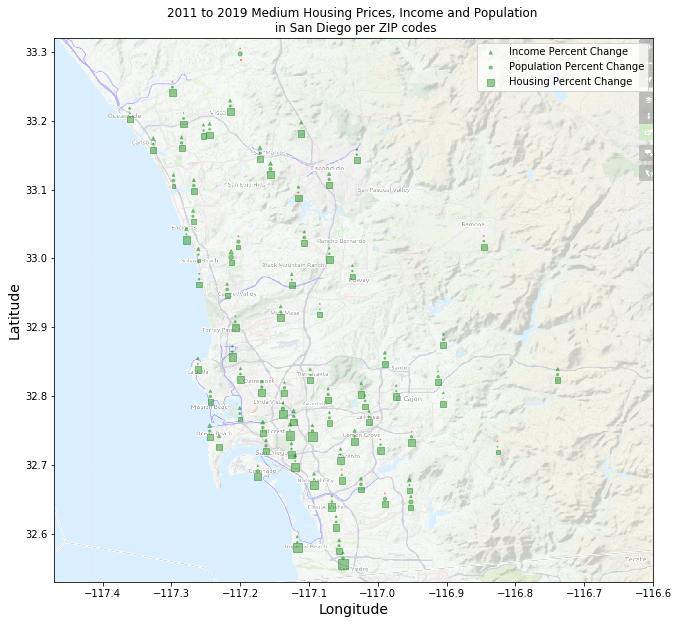

In [17]:


california_img=mpimg.imread('SanDiego.png')

fig, ax = plt.subplots(figsize=(20, 10))    
plt.scatter(chg_result_set["longitude"],chg_result_set["latitude"]+.016,marker="^",facecolor=col_inc,s=col_isize,label="Income Percent Change", alpha=0.4)
plt.scatter(chg_result_set["longitude"],chg_result_set["latitude"]+.008,marker="o",facecolor=col_pop,s=col_psize,label="Population Percent Change", alpha=0.4)
plt.scatter(chg_result_set["longitude"],chg_result_set["latitude"], marker="s",facecolor=col_home,s=col_hsize, label="Housing Percent Change",alpha=0.4)

plt.imshow(california_img, extent=[-117.47, -116.6, 32.53, 33.32], alpha=0.4)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=10)
plt.title("2011 to 2019 Medium Housing Prices, Income and Population \n in San Diego per ZIP codes")
plt.savefig("SD_Values_2011_t0_2017.png", bbox_inches='tight')
plt.show()

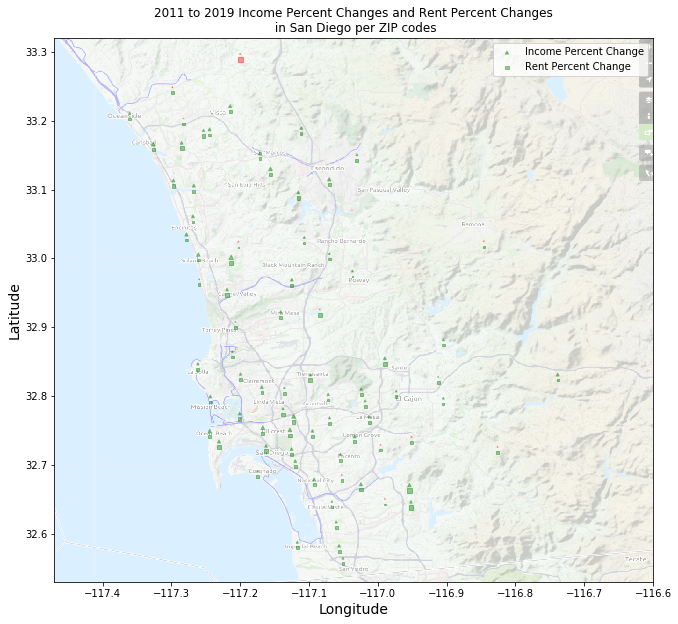

In [18]:
california_img=mpimg.imread('SanDiego.png')
col_rent=[]
col_rsize=[]

for x in chg_result_set.rent_chg:
    if x>0:
        col_rent.append("g")
        col_rsize.append(x/2)
    else:
        col_rent.append("r")
        col_rsize.append(1)


fig, ax = plt.subplots(figsize=(20, 10))    
plt.scatter(chg_result_set["longitude"],chg_result_set["latitude"]+.008,marker="^",facecolor=col_inc,s=col_isize,label="Income Percent Change", alpha=0.4)
plt.scatter(chg_result_set["longitude"],chg_result_set["latitude"], marker="s",facecolor=col_home,s=col_rsize, label="Rent Percent Change",alpha=0.4)

plt.title("2011 to 2019 Income Percent Changes and Rent Percent Changes\n in San Diego per ZIP codes")

plt.imshow(california_img, extent=[-117.47, -116.6, 32.53, 33.32], alpha=0.4)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=10)
plt.savefig("SD_Rent_2011_t0_2017.png", bbox_inches='tight')
plt.show()